In [1]:
import pandas as pd
import numpy as np
import json

from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [3]:
# aggregating data_list
def create_aggregated_dataframe(data_list):
    rows = []
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence, measurements in sequence_data.items():
                    # Convert to numpy array for easier aggregation
                    scores_array = np.array(measurements)
                    
                    # Calculate the mean, sum, max, and min along the rows
                    mean_scores = np.mean(scores_array, axis=0)
                    var_scores = np.var(scores_array, axis=0)
                    max_scores = np.max(scores_array, axis=0)
                    min_scores = np.min(scores_array, axis=0)
                    skew_scores = skew(scores_array, axis=0)
                    kurtosis_scores = kurtosis(scores_array, axis=0)

                    transcript_position = {
                        'transcript_id': transcript_id,
                        'transcript_position': position,
                    }
                    
                    for idx in range(scores_array.shape[1]): 

                        transcript_position.update({
                            f'mean {idx}': mean_scores[idx],
                            f'var {idx}': var_scores[idx],
                            f'max {idx}': max_scores[idx],
                            f'min {idx}': min_scores[idx],
                            f'skewness {idx}': skew_scores[idx],
                            f'kurtosis {idx}': kurtosis_scores[idx]
                        })
                    rows.append(transcript_position)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df

# Create the DataFrame
aggregated_df = create_aggregated_dataframe(data_list)

In [77]:
df_labels['transcript_position'] = df_labels['transcript_position'].astype(int)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)

In [228]:
df_full = pd.merge(aggregated_df, df_labels[['gene_id','transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')
print(df_full.columns)
df = df_full.drop([
    'transcript_id',
    'transcript_position',
], axis = 1)

Index(['transcript_id', 'transcript_position', 'mean 0', 'var 0', 'max 0',
       'min 0', 'skewness 0', 'kurtosis 0', 'mean 1', 'var 1', 'max 1',
       'min 1', 'skewness 1', 'kurtosis 1', 'mean 2', 'var 2', 'max 2',
       'min 2', 'skewness 2', 'kurtosis 2', 'mean 3', 'var 3', 'max 3',
       'min 3', 'skewness 3', 'kurtosis 3', 'mean 4', 'var 4', 'max 4',
       'min 4', 'skewness 4', 'kurtosis 4', 'mean 5', 'var 5', 'max 5',
       'min 5', 'skewness 5', 'kurtosis 5', 'mean 6', 'var 6', 'max 6',
       'min 6', 'skewness 6', 'kurtosis 6', 'mean 7', 'var 7', 'max 7',
       'min 7', 'skewness 7', 'kurtosis 7', 'mean 8', 'var 8', 'max 8',
       'min 8', 'skewness 8', 'kurtosis 8', 'gene_id', 'label'],
      dtype='object')


In [229]:
cluster_data = pd.read_pickle("clustered_dat_noscale.pkl")
pd.set_option('display.max_columns', None)
cluster_data['position'] = cluster_data['position'].astype(int)
merged_df = pd.merge(df_full, cluster_data, left_on=['transcript_id', 'transcript_position'], right_on=['transcript_id', 'position'], how='left')
df_full = merged_df.copy()
df = merged_df.drop(['transcript_id', 'transcript_position', 'position', 'rna_sequence'], axis=1)

In [230]:
print(df_full.columns)

Index(['transcript_id', 'transcript_position', 'mean 0', 'var 0', 'max 0',
       'min 0', 'skewness 0', 'kurtosis 0', 'mean 1', 'var 1', 'max 1',
       'min 1', 'skewness 1', 'kurtosis 1', 'mean 2', 'var 2', 'max 2',
       'min 2', 'skewness 2', 'kurtosis 2', 'mean 3', 'var 3', 'max 3',
       'min 3', 'skewness 3', 'kurtosis 3', 'mean 4', 'var 4', 'max 4',
       'min 4', 'skewness 4', 'kurtosis 4', 'mean 5', 'var 5', 'max 5',
       'min 5', 'skewness 5', 'kurtosis 5', 'mean 6', 'var 6', 'max 6',
       'min 6', 'skewness 6', 'kurtosis 6', 'mean 7', 'var 7', 'max 7',
       'min 7', 'skewness 7', 'kurtosis 7', 'mean 8', 'var 8', 'max 8',
       'min 8', 'skewness 8', 'kurtosis 8', 'gene_id', 'label', 'position',
       'rna_sequence', 'centroid_distance_set1', 'cluster_size_0_set1',
       'cluster_size_1_set1', 'inertia_set1', 'silhouette_score_set1',
       'variance_cluster_0_set1', 'variance_cluster_1_set1',
       'density_cluster_0_set1', 'density_cluster_1_set1',
       'ce

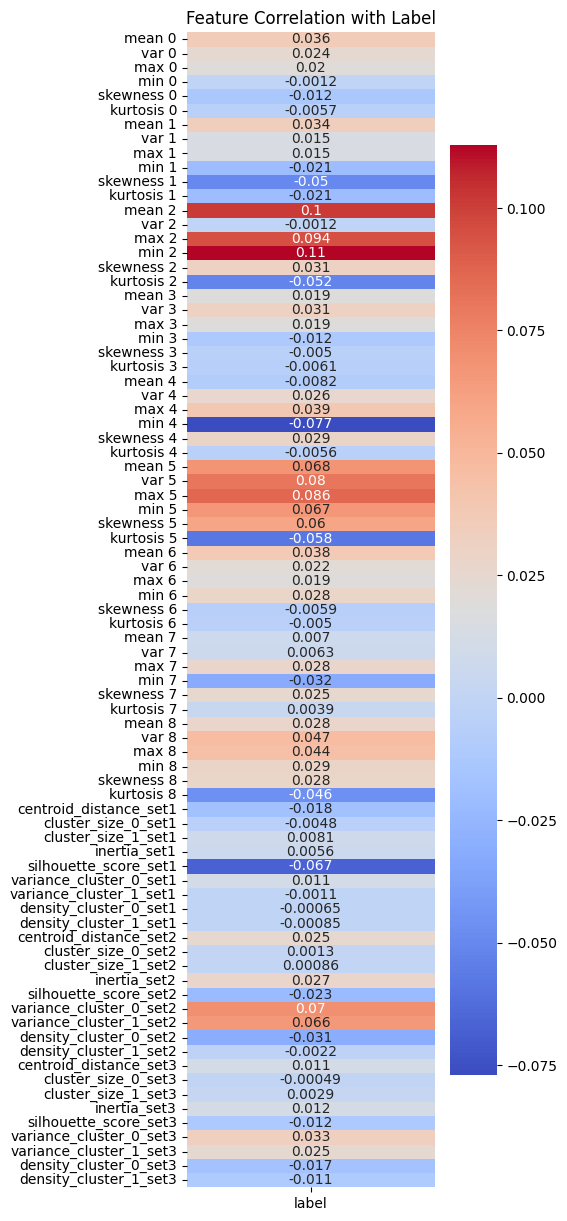

In [81]:
correlation_df = df.drop(['gene_id'], axis=1)
correlation_matrix = correlation_df.corr()
label_correlations = correlation_matrix['label'].drop('label')

# top_10_features = label_correlations.abs().nlargest(10)

plt.figure(figsize=(4, 15))
sns.heatmap(label_correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Feature Correlation with Label')
plt.show()

In [231]:
print(df_full.columns)

Index(['transcript_id', 'transcript_position', 'mean 0', 'var 0', 'max 0',
       'min 0', 'skewness 0', 'kurtosis 0', 'mean 1', 'var 1', 'max 1',
       'min 1', 'skewness 1', 'kurtosis 1', 'mean 2', 'var 2', 'max 2',
       'min 2', 'skewness 2', 'kurtosis 2', 'mean 3', 'var 3', 'max 3',
       'min 3', 'skewness 3', 'kurtosis 3', 'mean 4', 'var 4', 'max 4',
       'min 4', 'skewness 4', 'kurtosis 4', 'mean 5', 'var 5', 'max 5',
       'min 5', 'skewness 5', 'kurtosis 5', 'mean 6', 'var 6', 'max 6',
       'min 6', 'skewness 6', 'kurtosis 6', 'mean 7', 'var 7', 'max 7',
       'min 7', 'skewness 7', 'kurtosis 7', 'mean 8', 'var 8', 'max 8',
       'min 8', 'skewness 8', 'kurtosis 8', 'gene_id', 'label', 'position',
       'rna_sequence', 'centroid_distance_set1', 'cluster_size_0_set1',
       'cluster_size_1_set1', 'inertia_set1', 'silhouette_score_set1',
       'variance_cluster_0_set1', 'variance_cluster_1_set1',
       'density_cluster_0_set1', 'density_cluster_1_set1',
       'ce

In [232]:
df_full1 = df_full.drop(['transcript_id', 'transcript_position', 'gene_id', 'position',
       'rna_sequence'],axis=1)

# display(df_full1)

anom = df_full1[df_full1.label == 1]
clean = df_full1[df_full1.label == 0]

# clean_undersampled = clean.sample(
#     int(len(anom) * 15),
#     random_state=42
# )

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([anom, clean])

visualisation_initial1=visualisation_initial.copy()
column_names = list(visualisation_initial1.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, visualisation_initial.label.values

In [201]:
def sample_with_ratio(group):
    # Separate the group into label 1 and label 0
    label_1 = group[group['label'] == 1]
    label_0 = group[group['label'] == 0]
    
    # For label_1 data
    if len(label_0) == 0:
        # No label_0 data in group
        # Limit label_1 data to at most 5
        sample_label_1 = label_1.sample(n=min(len(label_1), 5), random_state=42)
        sample_label_0 = pd.DataFrame()  # No label_0 data
    else:
        # Calculate the maximum allowed label_1 instances (5:1 ratio)
        max_label_1 = 5 * len(label_0)
        
        if len(label_1) <= max_label_1:
            # Take all label_1 data
            sample_label_1 = label_1
        else:
            # Sample label_1 data to have len(label_1) = 5 * len(label_0)
            sample_label_1 = label_1.sample(n=max_label_1, random_state=42)
        
        # Limit label_0 data to at most 2 rows per group
        sample_label_0 = label_0.sample(n=min(len(label_0), 2), random_state=42)
    
    # Combine the two samples
    combined_sample = pd.concat([sample_label_1, sample_label_0])
    
    # Limit the total rows to 10 if necessary
    if len(combined_sample) > 10:
        combined_sample = combined_sample.sample(n=10, random_state=42)
    
    # Get the remaining data not included in the sample
    sampled_indices = combined_sample.index
    remaining_data = group.drop(sampled_indices)
    
    return combined_sample, remaining_data

sampled_list = []
remaining_list = []

# Group the DataFrame and apply the function
for name, group in df_train.groupby('gene_id'):
    sampled, remaining = sample_with_ratio(group)
    sampled_list.append(sampled)
    remaining_list.append(remaining)

# Combine the lists into DataFrames
df_full = pd.concat(sampled_list).reset_index(drop=True)
df_blind_test = pd.concat(remaining_list).reset_index(drop=True)

In [225]:
df_full1 = df_full.drop(['transcript_id', 'transcript_position', 'gene_id'],axis=1)

# display(df_full1)

anom = df_full1[df_full1.label == 1]
clean = df_full1[df_full1.label == 0]
# display(clean)
# clean_undersampled = clean.sample(
#     int(len(anom) * 15),
#     random_state=42
# )

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([anom, clean])

visualisation_initial1=visualisation_initial.copy()
column_names = list(visualisation_initial1.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, visualisation_initial.label.values

t-SNE plot (full data)

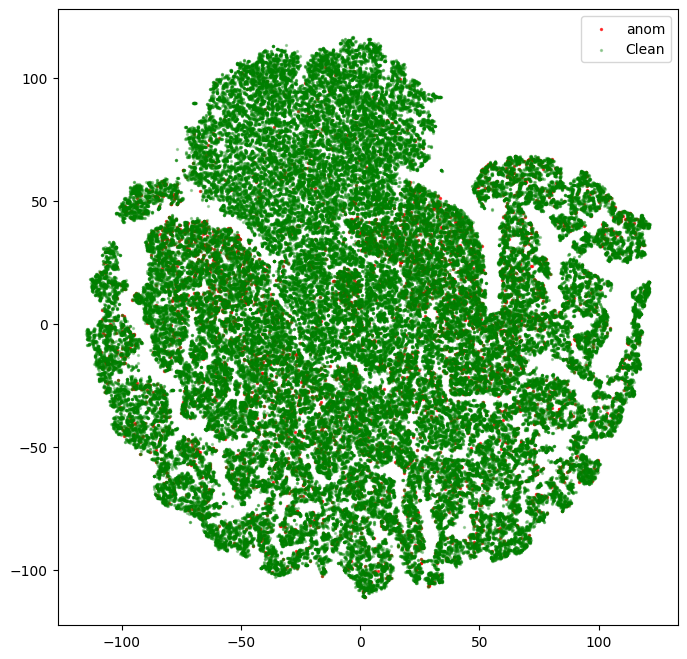

In [233]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='anom'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')


In [234]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {anom.shape}""")

Shape of the datasets:
    clean (rows, cols) = (116363, 82)
    fraud (rows, cols) = (5475, 82)


no resampling

In [235]:
RANDOM_SEED = 42
TRAINING_SAMPLE = 100000
VALIDATE_SIZE = 0.2

# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

clean_copy = clean.copy()
# training set: exlusively non-fraud transactions
X_train = clean_copy.drop('label', axis=1)

# clean.iloc[TRAINING_SAMPLE:]

# testing  set: the remaining non-fraud + all the fraud 
X_test = pd.concat([clean, anom]).sample(frac=1)

print(f"""Our testing set is composed as follows:
{X_test.label.value_counts()}""")

Our testing set is composed as follows:
label
0    116363
1      5475
Name: count, dtype: int64


train only on non-anomalous data

In [236]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [237]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (93090, 81)
    validate (rows, cols) = (23273, 81)
    holdout  (rows, cols) = (121838, 81)


In [238]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [239]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

In [240]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

In [252]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 64
EPOCHS = 30

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='relu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 16)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 81)             │         1,377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,709 (37.93 KB)

 Trainable params: 9,709 (37.93 KB)

 Non-trainable params: 0 (0.00 B)

array([[-0.23935764, -0.29709454, -0.90322485, ..., -0.10726328,
        -0.41514129, -0.13572011],
       [ 0.893908  ,  1.08966678,  0.16841877, ..., -0.7788921 ,
        -0.46475484, -0.05298874],
       [-0.97238469, -0.93759829, -1.2745865 , ...,  0.50946771,
        -0.42983538, -0.15201001],
       ...,
       [ 1.33575043,  0.26748286,  0.13077138, ...,  0.72587494,
        -0.34645091, -0.15210089],
       [-0.51026385, -0.33077033, -0.37870148, ..., -0.58437805,
         0.23535892,  0.12447194],
       [ 0.49474385,  0.20716458, -0.29452895, ...,  0.04025864,
        -0.4876909 , -0.11000339]])

In [253]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - acc: 0.0467 - loss: 0.0379 - val_acc: 0.2153 - val_loss: 0.0264
Epoch 2/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - acc: 0.2171 - loss: 0.0265 - val_acc: 0.2164 - val_loss: 0.0264
Epoch 3/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - acc: 0.2143 - loss: 0.0265 - val_acc: 0.2201 - val_loss: 0.0264
Epoch 4/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - acc: 0.2170 - loss: 0.0265 - val_acc: 0.2233 - val_loss: 0.0263
Epoch 5/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - acc: 0.2307 - loss: 0.0265 - val_acc: 0.2277 - val_loss: 0.0263
Epoch 6/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - acc: 0.2472 - loss: 0.0264 - val_acc: 0.2522 - val_loss: 0.0263
Epoch 7/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - acc: 0.2540 - loss: 0.0262 - val_acc: 0.2640 - val_loss: 0.0249
Epoch 8/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - acc: 0.2577 - loss: 0.0250 - val_acc: 0.2632 - val_loss: 0.0249
Epoch 9/30
1455/1455 ━━━

In [254]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

3808/3808 ━━━━━━━━━━━━━━━━━━━━ 2s 507us/step


In [255]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

In [256]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Assuming y_test contains the labels (0 for clean, 1 for anomalies/fraud)
# Compute ROC AUC
roc_auc = roc_auc_score(y_test, mse)

# Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, mse)
pr_auc = auc(recall, precision)

print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")

ROC AUC: 0.4177063689492851
PR AUC: 0.0351948298134854


plot is ass

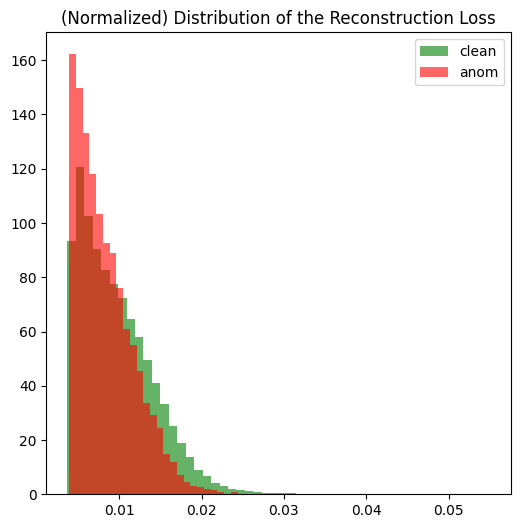

In [257]:
clean = mse[y_test==0]
anom = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(anom, bins=50, density=True, label="anom", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
# plt.xlim(0,0.2)
plt.show()


In [198]:
y = df_full[['label', 'transcript_id', 'transcript_position']]
x = df_full.drop(['label'], axis=1)

y = df_full[['label', 'transcript_id', 'transcript_position']]
x = df_full.drop(['label', 'position', 'rna_sequence'], axis=1)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
X_test = X_test.drop(['transcript_id', 'transcript_position', 'gene_id'], axis=1)
y_test = y_test['label']

In [200]:
df_train = pd.merge(X_train, y_train[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')

In [138]:
def sample_with_ratio(group):
    # Separate the group into label 1 and label 0
    label_1 = group[group['label'] == 1]
    label_0 = group[group['label'] == 0]
    
    # For label_1 data
    if len(label_0) == 0:
        # No label_0 data in group
        # Limit label_1 data to at most 5
        sample_label_1 = label_1.sample(n=min(len(label_1), 5), random_state=42)
        sample_label_0 = pd.DataFrame()  # No label_0 data
    else:
        # Calculate the maximum allowed label_1 instances (5:1 ratio)
        max_label_1 = 5 * len(label_0)
        
        if len(label_1) <= max_label_1:
            # Take all label_1 data
            sample_label_1 = label_1
        else:
            # Sample label_1 data to have len(label_1) = 5 * len(label_0)
            sample_label_1 = label_1.sample(n=max_label_1, random_state=42)
        
        # Limit label_0 data to at most 2 rows per group
        sample_label_0 = label_0.sample(n=min(len(label_0), 2), random_state=42)
    
    # Combine the two samples
    combined_sample = pd.concat([sample_label_1, sample_label_0])
    
    # Limit the total rows to 10 if necessary
    if len(combined_sample) > 10:
        combined_sample = combined_sample.sample(n=10, random_state=42)
    
    # Get the remaining data not included in the sample
    sampled_indices = combined_sample.index
    remaining_data = group.drop(sampled_indices)
    
    return combined_sample, remaining_data

sampled_list = []
remaining_list = []

# Group the DataFrame and apply the function
for name, group in df_train.groupby('gene_id'):
    sampled, remaining = sample_with_ratio(group)
    sampled_list.append(sampled)
    remaining_list.append(remaining)

# Combine the lists into DataFrames
df_full = pd.concat(sampled_list).reset_index(drop=True)
df_blind_test = pd.concat(remaining_list).reset_index(drop=True)

In [139]:
df_full = df_full.drop(['gene_id'], axis=1)
df_blind_test = df_blind_test.drop(['gene_id'], axis=1) # Extra from what was removed from the undersampling of 0s (A lot of 0s with some 1s)

x = df_full.drop(columns=['label'], axis=1)
x = x.drop(['transcript_id', 'transcript_position'], axis=1)
y_train = df_full['label']

x_blind = df_blind_test.drop(columns=['label'], axis=1)
x_blind = x_blind.drop(['transcript_id', 'transcript_position'], axis=1)
y_blind = df_blind_test['label']

In [140]:
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y_train)

# Comment this out to not use SMOTE
x, y_train = x_smote, y_smote

In [141]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x)
X_test_scaled = scaler.transform(X_test)

In [142]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
14965    1
14966    1
14967    1
14968    1
14969    1
Name: label, Length: 14970, dtype: int64

In [44]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_genuine = X_train_scaled[~y_train]
X_test_genuine = X_test_scaled[~y_test]

X_train_anom = X_train_scaled[y_train]
X_test_anom = X_test_scaled[y_test]

array([[-0.23935764, -0.29709454, -0.90322485, ..., -0.10726328,
        -0.41514129, -0.13572011],
       [ 0.893908  ,  1.08966678,  0.16841877, ..., -0.7788921 ,
        -0.46475484, -0.05298874],
       [-0.97238469, -0.93759829, -1.2745865 , ...,  0.50946771,
        -0.42983538, -0.15201001],
       ...,
       [ 2.10573416, -0.06904526, -0.41514954, ..., -0.6684716 ,
        -0.29193333, -0.11023251],
       [-0.09676056, -0.16143012, -0.5000322 , ..., -0.7900079 ,
        -0.44545298,  0.06270273],
       [-1.08550934, -0.99108427, -1.10482117, ..., -1.12777068,
         1.06712859,  0.3272489 ]])

In [45]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [68]:
CODE_DIM = 2
INPUT_SHAPE = X_train_scaled.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

autoencoder = Model(input_layer, output_layer, name='anomaly')

In [73]:
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [74]:
history = autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=25, batch_size=64,
                          validation_data=(X_test_scaled, X_test_scaled),
                        shuffle=True)

Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6672 - val_loss: 0.8229
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6666 - val_loss: 0.8231
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6635 - val_loss: 0.8225
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6639 - val_loss: 0.8214
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6656 - val_loss: 0.8222
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6633 - val_loss: 0.8229
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6634 - val_loss: 0.8245
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6650 - val_loss: 0.8234
Epoch 9/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6692 - val_loss: 0.8231
Epoch 10/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6624 - val_loss: 0.8210
Epoch 11/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6616 - val_loss: 0.8236
Epoch 12/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

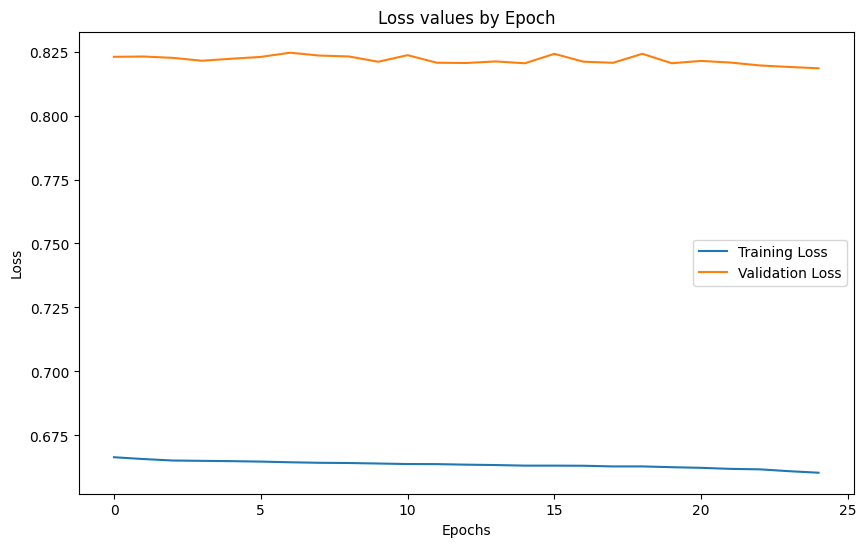

In [75]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [54]:
reconstructions = autoencoder.predict(X_test_scaled, verbose=0)
reconstruction_error = mae(reconstructions, X_test_scaled)

In [55]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.682536,False
1,0.622665,False
2,0.673962,False
3,0.583863,False
4,0.552405,False


In [56]:
def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

Threshold: 0.2947	Accuracy: 0.044		Precision: 0.522	Recall Score: 0.500
Threshold: 0.4971	Accuracy: 0.125		Precision: 0.472	Recall Score: 0.440
Threshold: 0.5427	Accuracy: 0.211		Precision: 0.476	Recall Score: 0.409
Threshold: 0.5779	Accuracy: 0.301		Precision: 0.480	Recall Score: 0.400
Threshold: 0.6110	Accuracy: 0.391		Precision: 0.481	Recall Score: 0.392
Threshold: 0.6429	Accuracy: 0.482		Precision: 0.482	Recall Score: 0.394
Threshold: 0.6784	Accuracy: 0.575		Precision: 0.483	Recall Score: 0.406
Threshold: 0.7183	Accuracy: 0.670		Precision: 0.486	Recall Score: 0.428
Threshold: 0.7718	Accuracy: 0.766		Precision: 0.488	Recall Score: 0.455
Threshold: 0.8603	Accuracy: 0.861		Precision: 0.490	Recall Score: 0.479


In [57]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.294685


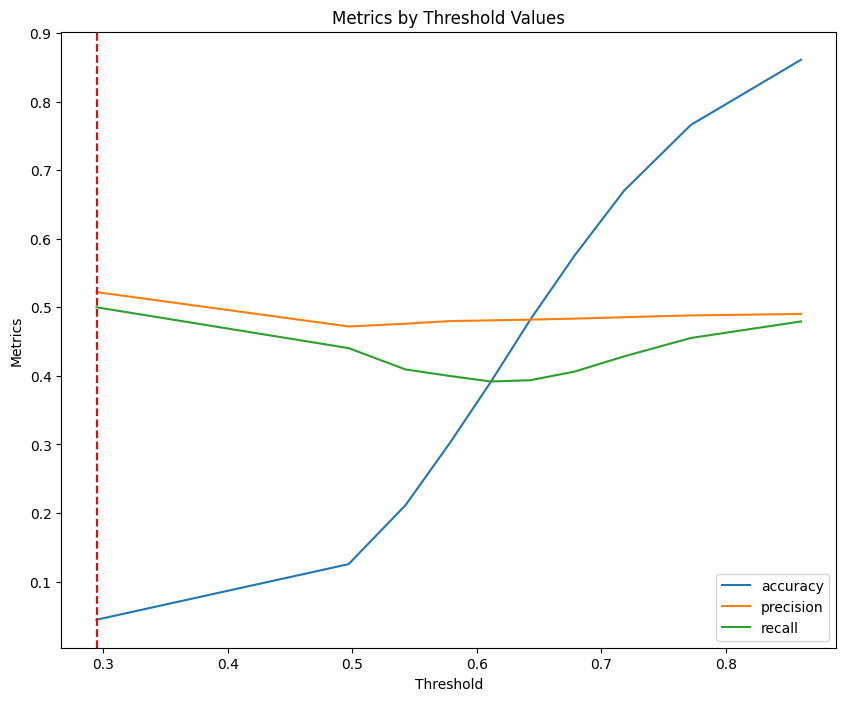

In [58]:
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

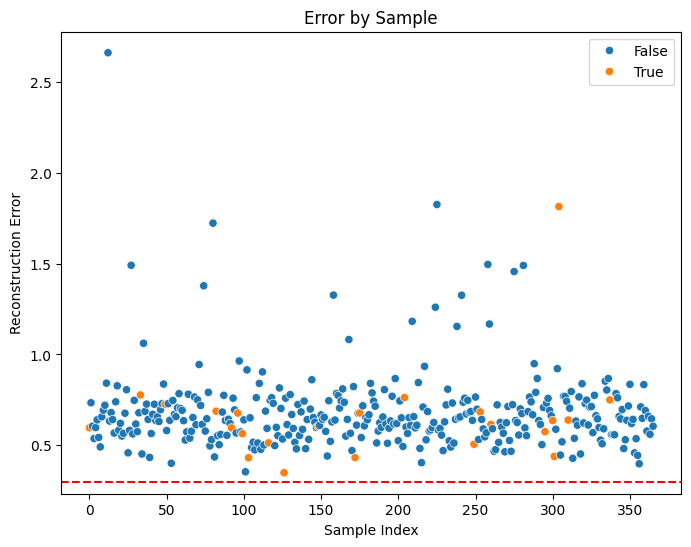

In [59]:
temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')
plt.legend()
plt.show()

In [60]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,0.682536,False,True
1,0.622665,False,True
2,0.673962,False,True
3,0.583863,False,True
4,0.552405,False,True


In [61]:
print(classification_report(recons_df['y_true'],recons_df['y_pred']))

              precision    recall  f1-score   support

       False       1.00      0.00      0.00     34934
        True       0.04      1.00      0.08      1618

    accuracy                           0.04     36552
   macro avg       0.52      0.50      0.04     36552
weighted avg       0.96      0.04      0.00     36552



In [62]:
print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")

Recall Score: 100.000%
Accuracy Score: 4.429%


#### Random Forest

In [196]:
### RANDOM FOREST
print("Random Forest")
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Random Forest
Test Data Set
Accuracy: 0.8862442547603414
ROC AUC: 0.8933763088339707
PR AUC: 0.3541099784613377
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     34934
           1       0.24      0.71      0.36      1618

    accuracy                           0.89     36552
   macro avg       0.61      0.80      0.65     36552
weighted avg       0.95      0.89      0.91     36552



Text(0.5, 1.0, 'Train Precision-Recall curve')

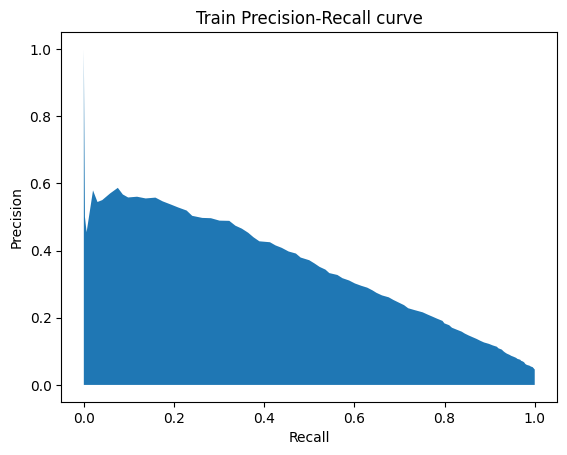

In [197]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")

In [18]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)

#Takes about 4 minutes for me (yucai) to run this

# Parameters grid
param_grid = {
    'n_estimators': [500, 700, 900], # Default = 100
    'max_depth': [None, 5, 10], # Default = None
    'min_samples_split': [1, 2, 3], # Default = 2
    'min_samples_leaf': [1, 2, 4] # Default = 1
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\base.py", line 666, in _validate_params
  

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}


In [19]:
# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Test Data Set
Accuracy: 0.8833716349310571
ROC AUC: 0.8888860910924661
PR AUC: 0.34481204334773224
              precision    recall  f1-score   support

           0       0.98      0.89      0.94     46561
           1       0.23      0.71      0.35      2175

    accuracy                           0.88     48736
   macro avg       0.61      0.80      0.64     48736
weighted avg       0.95      0.88      0.91     48736



#### XGBoost

In [212]:
### XBOOST
print("XGBoost")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

XGBoost


c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.882715036112935
ROC AUC: 0.8968491033382887
PR AUC: 0.3921156109367431
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     34934
           1       0.24      0.73      0.36      1618

    accuracy                           0.88     36552
   macro avg       0.61      0.81      0.65     36552
weighted avg       0.95      0.88      0.91     36552



In [21]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Takes ~2 minutes to run

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 800], # Default = 100
    'max_depth': [3, 6, 9, 12], # Default = 6
    'learning_rate': [0.01, 0.1, 0.2], 
    'subsample': [0.6, 0.8, 1.0], # Default = 1
    'colsample_bytree': [0.6, 0.8, 1.0], # Default = 1
    'gamma': [0, 0.1, 0.2] # Default = 0
}

xgb_clf = xgb.XGBClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)


Best parameters found:  {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [213]:
best_params = random_search.best_params_

print("XGBoost")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

XGBoost


c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8998413219522872
ROC AUC: 0.909954727979719
PR AUC: 0.4123114317074919
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     34934
           1       0.27      0.73      0.39      1618

    accuracy                           0.90     36552
   macro avg       0.63      0.82      0.67     36552
weighted avg       0.95      0.90      0.92     36552

